In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iterativestratification/iterative-stratification-master/setup.py
/kaggle/input/iterativestratification/iterative-stratification-master/.travis.yml
/kaggle/input/iterativestratification/iterative-stratification-master/setup.cfg
/kaggle/input/iterativestratification/iterative-stratification-master/.gitignore
/kaggle/input/iterativestratification/iterative-stratification-master/LICENSE
/kaggle/input/iterativestratification/iterative-stratification-master/README.md
/kaggle/input/iterativestratification/iterative-stratification-master/iterstrat/__init__.py
/kaggle/input/iterativestratification/iterative-stratification-master/iterstrat/ml_stratifiers.py
/kaggle/input/iterativestratification/iterative-stratification-master/tests/__init__.py
/kaggle/input/iterativestratification/iterative-stratification-master/tests/test_ml_stratifiers.py
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_drug.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggl

In [15]:
import warnings
warnings.filterwarnings("ignore")

# Adding iterative-stratification 
# Select add data from the right menu and search for iterative-stratification, then add it to your kernel.
import sys
sys.path.append('../input/iterativestratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold


from time import time
import datetime
import gc

import numpy as np
import pandas as pd 

# ML tools 
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
import tensorflow as tf 
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from sklearn.metrics import log_loss
from tensorflow_addons.layers import WeightNormalization
# Setting random seeds
np.random.seed(42)
tf.random.set_seed(42)

# Visualization tools
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('white')
sns.set(font_scale=1.2)

In [16]:
df_train = pd.read_csv('/kaggle/input/lish-moa/train_features.csv')
display(df_train.head(3))
print('train data size', df_train.shape)

df_target_ns = pd.read_csv('/kaggle/input/lish-moa/train_targets_nonscored.csv')
display(df_target_ns.head(3))
print('train target nonscored size', df_target_ns.shape)


df_target_s = pd.read_csv('/kaggle/input/lish-moa/train_targets_scored.csv')
display(df_target_s.head(3))
print('train target scored size', df_target_s.shape)


df_test = pd.read_csv('/kaggle/input/lish-moa/test_features.csv')
display(df_test.head(3))
print('test data size', df_test.shape)

df_sample = pd.read_csv('/kaggle/input/lish-moa/sample_submission.csv')
display(df_sample.head(3))
print('sample submission size', df_sample.shape)

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931


train data size (23814, 876)


,sig_id,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train target nonscored size (23814, 403)


,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


train target scored size (23814, 207)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0004d9e33,trt_cp,24,D1,-0.5458,0.1306,-0.5135,0.4408,1.5500,-0.1644,...,0.0981,0.7978,-0.143,-0.2067,-0.2303,-0.1193,0.0210,-0.0502,0.1510,-0.7750
1,id_001897cda,trt_cp,72,D1,-0.1829,0.2320,1.2080,-0.4522,-0.3652,-0.3319,...,-0.1190,-0.1852,-1.031,-1.3670,-0.3690,-0.5382,0.0359,-0.4764,-1.3810,-0.7300
2,id_002429b5b,ctl_vehicle,24,D1,0.1852,-0.1404,-0.3911,0.1310,-1.4380,0.2455,...,-0.2261,0.3370,-1.384,0.8604,-1.9530,-1.0140,0.8662,1.0160,0.4924,-0.1942


test data size (3982, 876)


,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,id_001897cda,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,id_002429b5b,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


sample submission size (3982, 207)


In [17]:
print(df_train.isnull().sum().any()) # True if there are missing values
print(df_train.info())

False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23814 entries, 0 to 23813
Columns: 876 entries, sig_id to c-99
dtypes: float64(872), int64(1), object(3)
memory usage: 159.2+ MB
None


In [18]:
display(df_train.select_dtypes('int64').head(3))
display(df_train.select_dtypes('object').head(3))

,cp_time
0,24
1,72
2,48


,sig_id,cp_type,cp_dose
0,id_000644bb2,trt_cp,D1
1,id_000779bfc,trt_cp,D1
2,id_000a6266a,trt_cp,D1


In [19]:
g_features = [cols for cols in df_train.columns if cols.startswith('g-')]

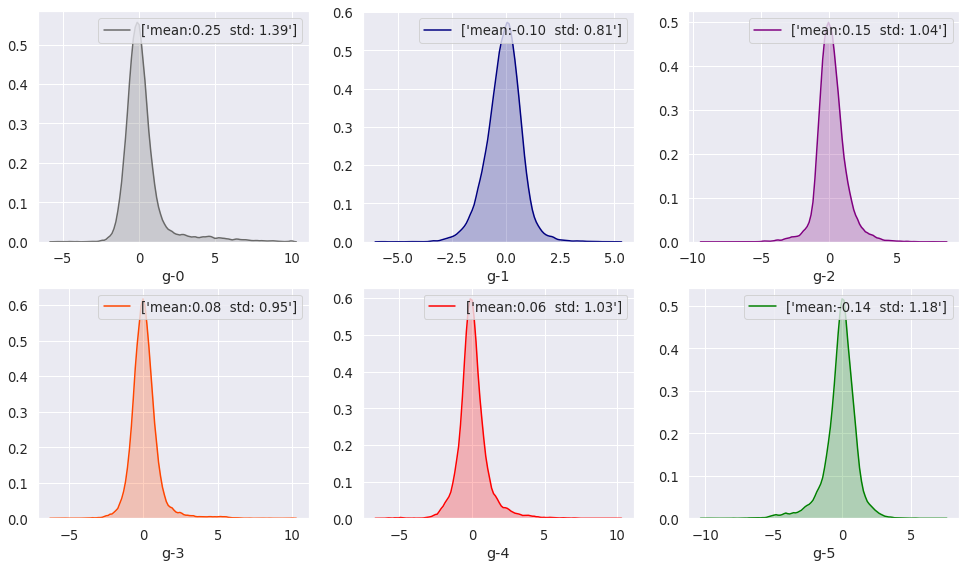

In [20]:
color = ['dimgray','navy','purple','orangered', 'red', 'green' ,'mediumorchid', 'khaki', 'salmon', 'blue','cornflowerblue','mediumseagreen']
 
color_ind=0
n_row = 6
n_col = 3
n_sub = 1 
plt.rcParams["legend.loc"] = 'upper right'
fig = plt.figure(figsize=(8,14))
plt.subplots_adjust(left=-0.3, right=1.3,bottom=-0.3,top=1.3)
for i in (np.arange(0,6,1)):
    plt.subplot(n_row, n_col, n_sub)
    sns.kdeplot(df_train.loc[:,g_features[i]],color=color[color_ind],shade=True,
                 label=['mean:'+str('{:.2f}'.format(df_train.loc[:,g_features[i]].mean()))
                        +'  ''std: '+str('{:.2f}'.format(df_train.loc[:,g_features[i]].std()))])
    
    plt.xlabel(g_features[i])
    plt.legend()                    
    n_sub+=1
    color_ind+=1
plt.show()

In [21]:
c_features = [cols for cols in df_train.columns if cols.startswith('c-')]

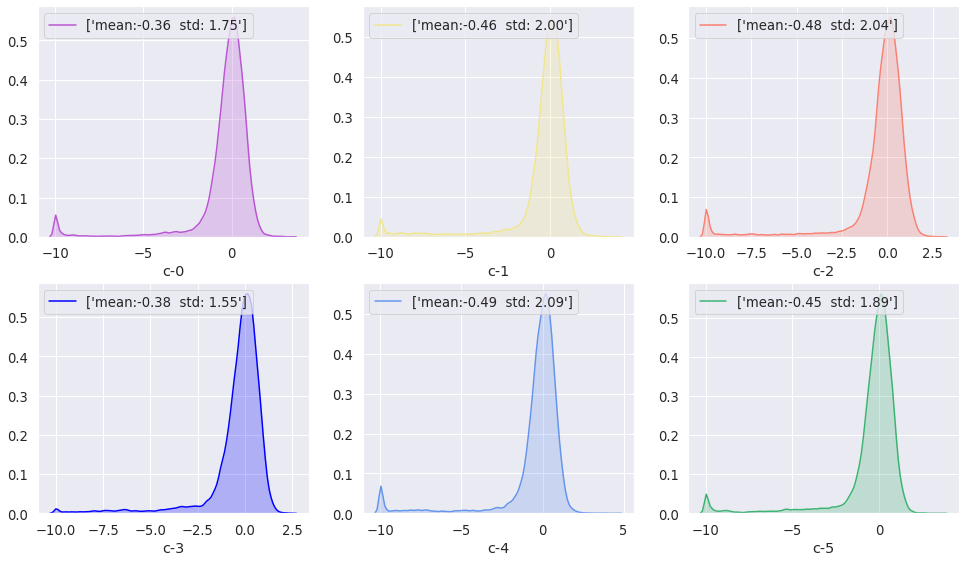

In [22]:
n_row = 6
n_col = 3
n_sub = 1 
fig = plt.figure(figsize=(8,14))
plt.subplots_adjust(left=-0.3, right=1.3,bottom=-0.3,top=1.3)
plt.rcParams["legend.loc"] = 'upper left'
for i in (np.arange(0,6,1)):
    plt.subplot(n_row, n_col, n_sub)
    sns.kdeplot(df_train.loc[:,c_features[i]],color=color[color_ind],shade=True,
                 label=['mean:'+str('{:.2f}'.format(df_train.loc[:,c_features[i]].mean()))
                        +'  ''std: '+str('{:.2f}'.format(df_train.loc[:,c_features[i]].std()))])
    
    plt.xlabel(c_features[i])
    plt.legend()                    
    n_sub+=1
    color_ind+=1
plt.show()

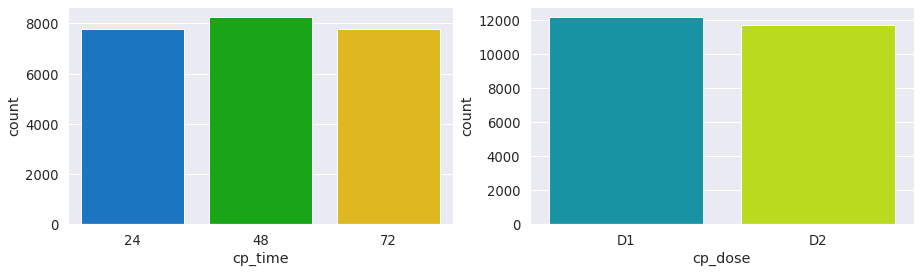

In [23]:
fig = plt.figure(figsize=(10,4))
plt.subplots_adjust(right=1.3)
plt.subplot(1, 2, 1)
sns.countplot(df_train['cp_time'],palette='nipy_spectral')
plt.subplot(1, 2, 2)
sns.countplot(df_train['cp_dose'],palette='nipy_spectral')
plt.show()

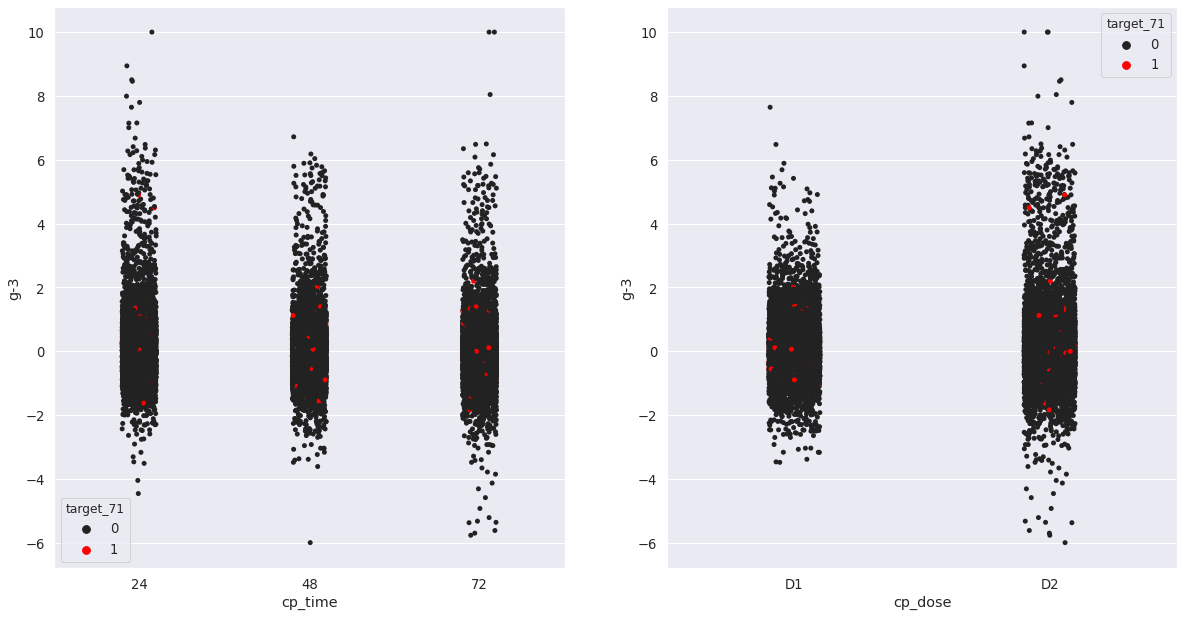

In [24]:
train_copy= df_train.copy()
train_copy['target_71'] = df_target_s.iloc[:,72] # sig_id is included
fig = plt.figure(figsize=(16,8))
plt.subplots_adjust(right=1.1,top=1.1)
ax1 = fig.add_subplot(121)
sns.stripplot(data= train_copy , x='cp_time', y= 'g-3',color='red', hue='target_71',ax=ax1)
ax2 = fig.add_subplot(122)
sns.stripplot(data= train_copy , x='cp_dose', y= 'g-3',color='red', hue='target_71',ax=ax2)
plt.show()

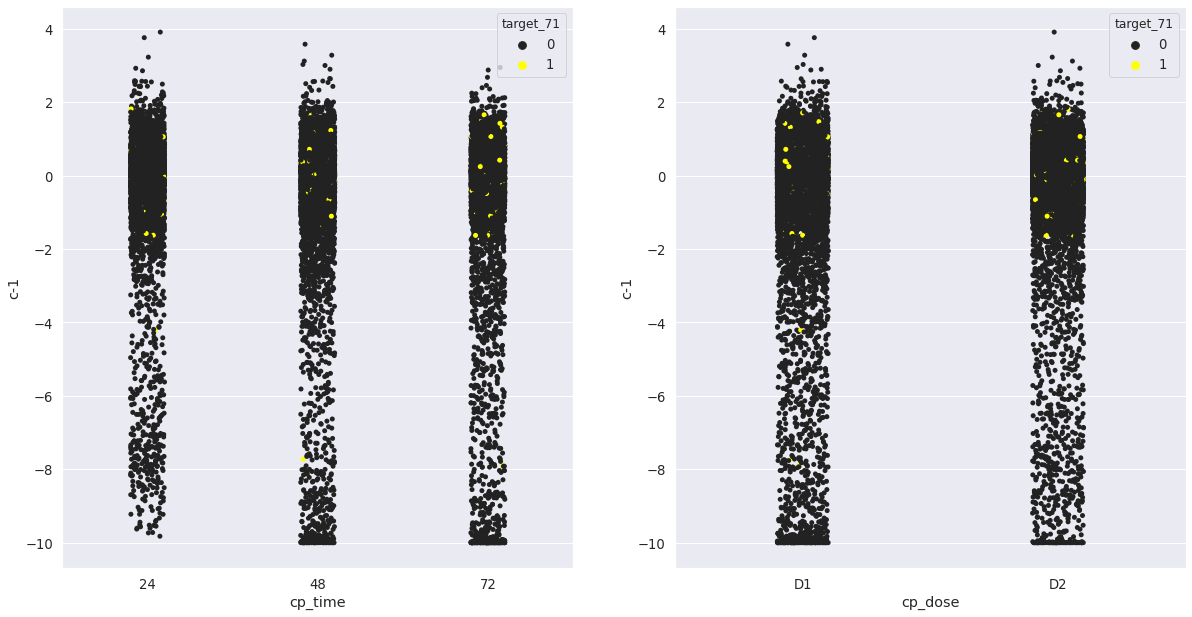

In [25]:
fig = plt.figure(figsize=(16,8))
plt.subplots_adjust(right=1.1,top=1.1)
ax1 = fig.add_subplot(121)
sns.stripplot(data= train_copy, x='cp_time', y= 'c-1',color='yellow', hue='target_71',ax=ax1)
ax2 = fig.add_subplot(122)
sns.stripplot(data= train_copy , x='cp_dose', y= 'c-1',color='yellow', hue='target_71',ax=ax2)
plt.show()

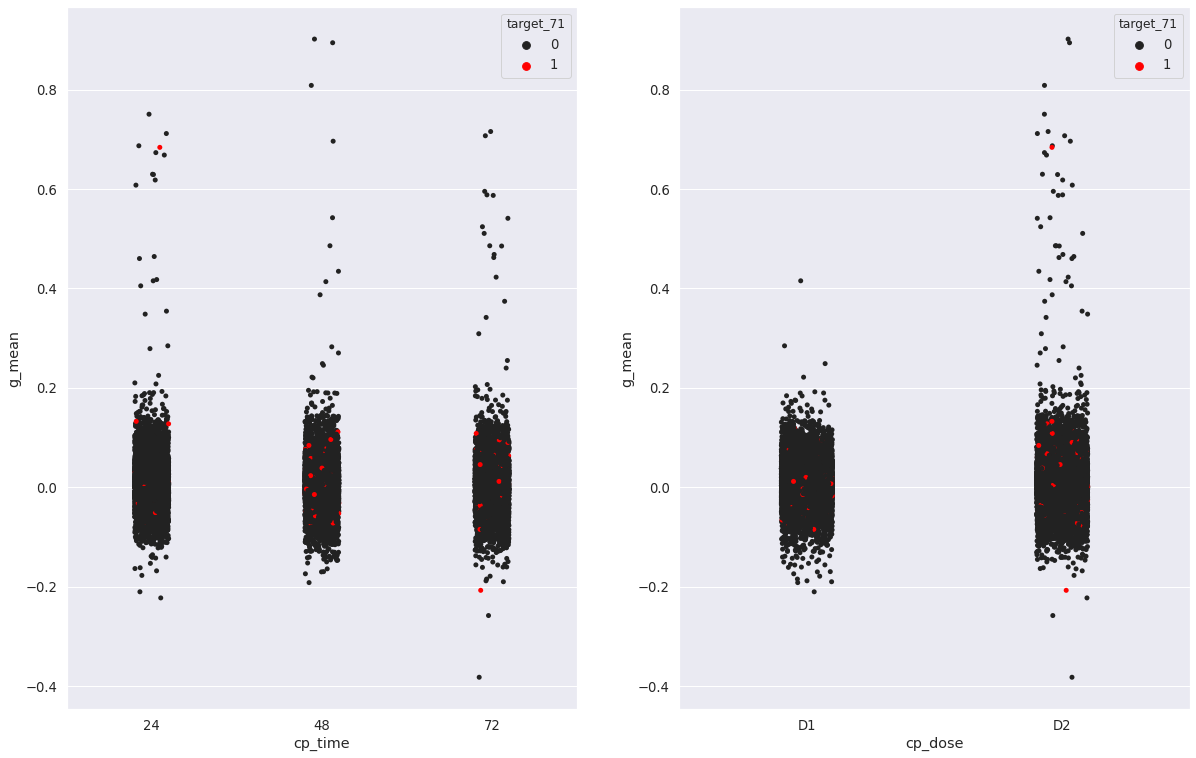

In [26]:
train_copy['g_mean'] = train_copy.loc[:, g_features].mean(axis=1) 
fig = plt.figure(figsize=(16,10))
plt.subplots_adjust(right=1.1,top=1.1)
ax1 = fig.add_subplot(121)
sns.stripplot(data= train_copy , x='cp_time', y= 'g_mean',color='red', hue='target_71',ax=ax1)
ax2 = fig.add_subplot(122)
sns.stripplot(data= train_copy , x='cp_dose', y= 'g_mean', color='red', hue='target_71',ax=ax2)
plt.show()

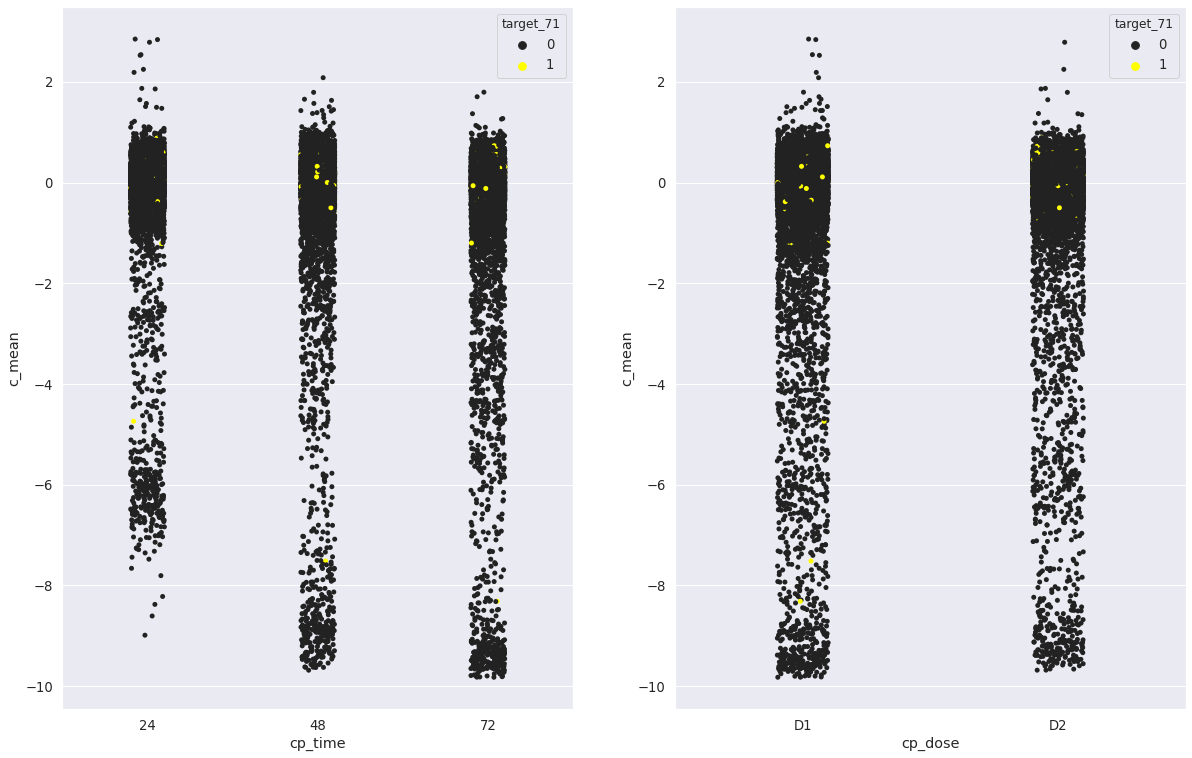

In [27]:
train_copy['c_mean'] = train_copy.loc[:, c_features].mean(axis=1) 
fig = plt.figure(figsize=(16,10))
plt.subplots_adjust(right=1.1,top=1.1)
ax1 = fig.add_subplot(121)
sns.stripplot(data= train_copy, x='cp_time', y= 'c_mean',color='yellow', hue='target_71',ax=ax1)
ax2 = fig.add_subplot(122)
sns.stripplot(data= train_copy , x='cp_dose', y= 'c_mean', color='yellow', hue='target_71',ax=ax2)
plt.show()

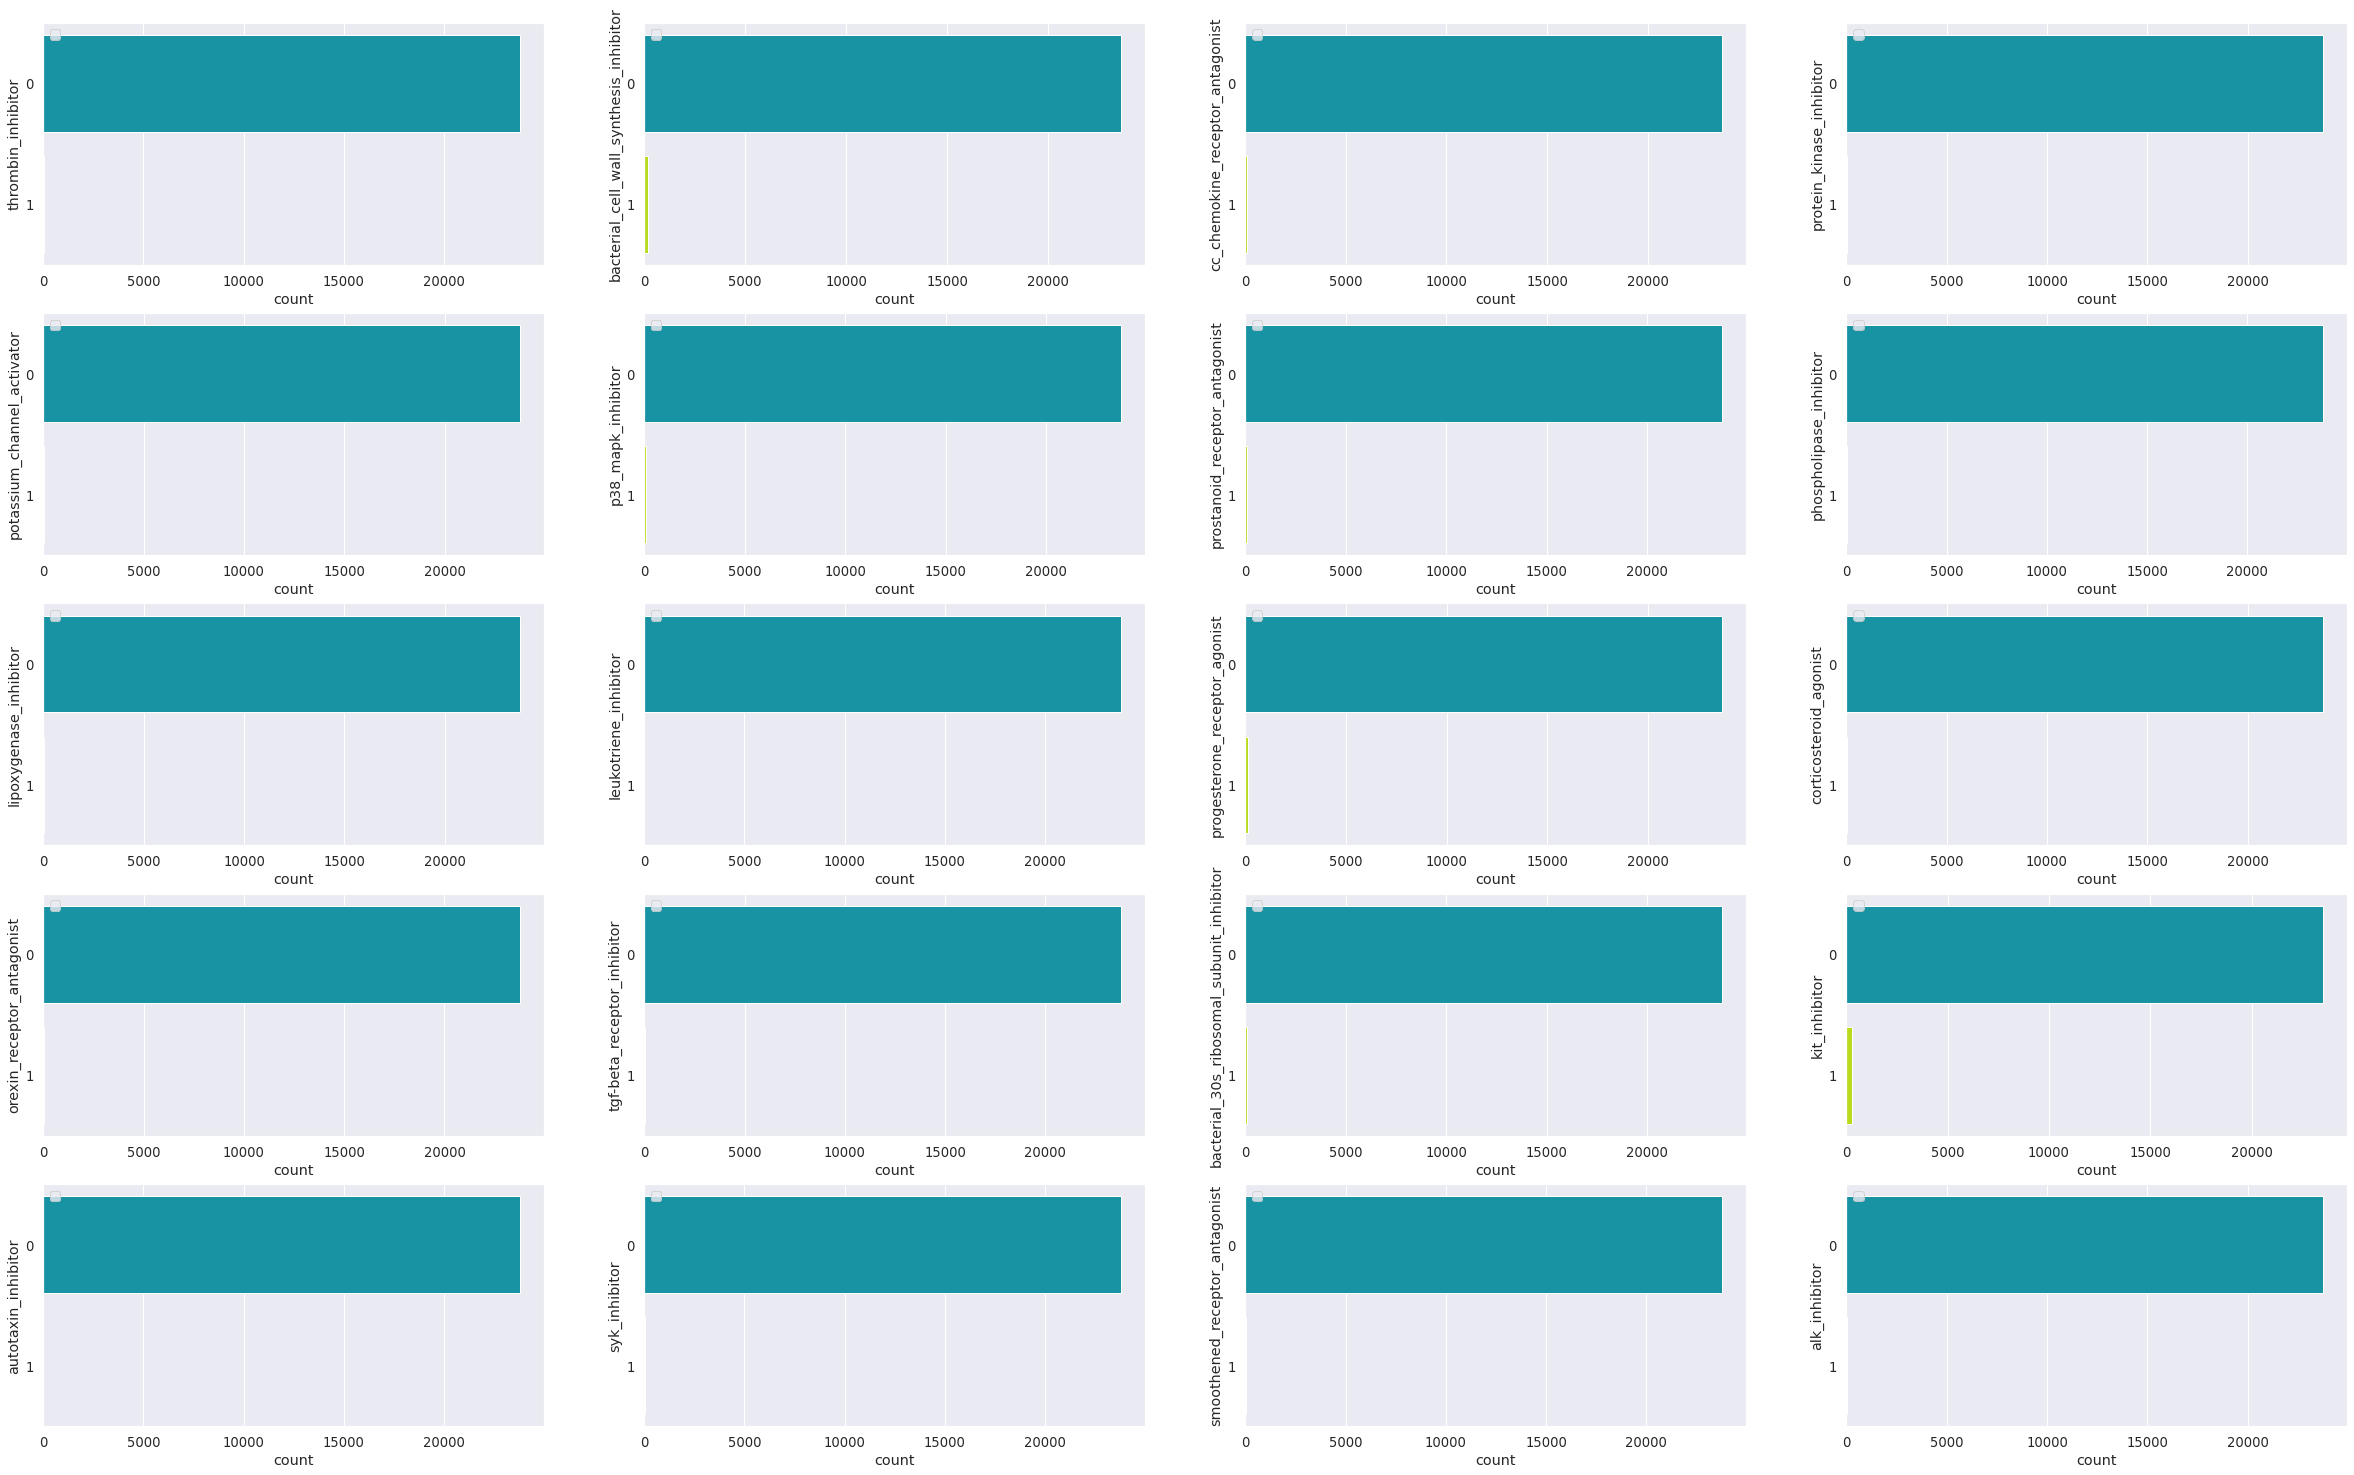

In [28]:
target_s_copy = df_target_s.copy()
target_s_copy.drop('sig_id', axis=1, inplace=True)
n_row = 20
n_col = 4 
n_sub = 1   
fig = plt.figure(figsize=(20,50))
plt.subplots_adjust(left=-0.3, right=1.3,bottom=-0.3,top=1.3)
for i in np.random.choice(np.arange(0,target_s_copy.shape[1],1),n_row):
    plt.subplot(n_row, n_col, n_sub)
    sns.countplot(y=target_s_copy.iloc[:, i],palette='nipy_spectral',orient='h')
    
    plt.legend()                    
    n_sub+=1
plt.show()

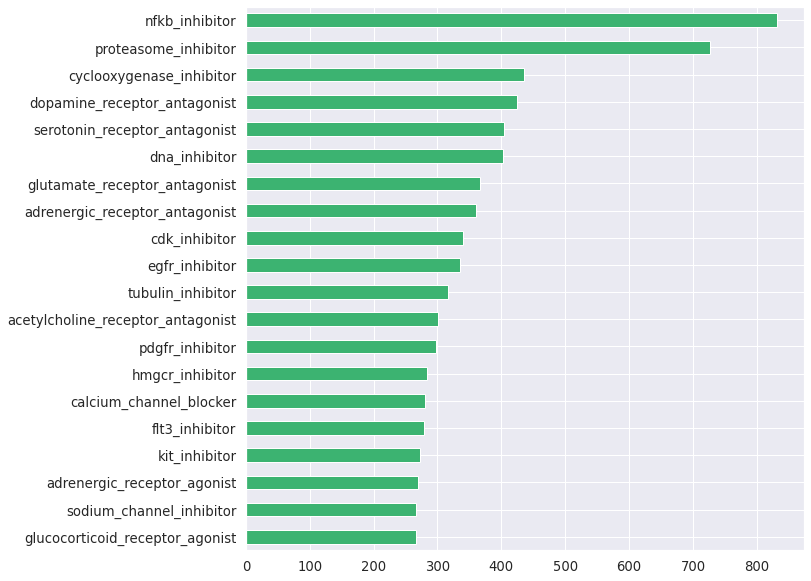

In [29]:
plt.figure(figsize=(10,10))
target_s_copy.sum().sort_values()[-20:].plot(kind='barh',color='mediumseagreen')
plt.show()

In [ ]:
target_ns_copy = df_target_ns.copy()
target_ns_copy.drop('sig_id', axis=1, inplace=True)
n_row = 20
n_col = 4 
n_sub = 1   
fig = plt.figure(figsize=(20,50))
plt.subplots_adjust(left=-0.3, right=1.3,bottom=-0.3,top=1.3)
for i in np.random.choice(np.arange(0,target_ns_copy.shape[1],1),n_row):
    plt.subplot(n_row, n_col, n_sub)
    sns.countplot(y=target_ns_copy.iloc[:, i],palette='magma',orient='h')
    
    plt.legend()                    
    n_sub+=1
plt.show()

In [ ]:
plt.figure(figsize=(10,10))
target_ns_copy.sum().sort_values()[-20:].plot(kind='barh',color='purple')
plt.show()

## Preprocess

In [ ]:
ind_tr = df_train[df_train['cp_type']=='ctl_vehicle'].index
ind_te = df_test[df_test['cp_type']=='ctl_vehicle'].index

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
transformer = QuantileTransformer(n_quantiles=100,random_state=42, output_distribution="normal")

def preprocess(df):
    df['cp_time'] = df['cp_time'].map({24:1, 48:2, 72:3})
    df['cp_dose'] = df['cp_dose'].map({'D1':0, 'D2':1})
    g_features = [cols for cols in df.columns if cols.startswith('g-')]
    c_features = [cols for cols in df.columns if cols.startswith('c-')]
    for col in (g_features + c_features):
        vec_len = len(df[col].values)
        raw_vec = df[col].values.reshape(vec_len, 1)
        transformer.fit(raw_vec)
        df[col] = transformer.transform(raw_vec).reshape(1, vec_len)[0]
    return df

X = preprocess(df_train)
X_test = preprocess(df_test)

display(X.head(5))
print('Train data size', X.shape)
display(X_test.head(3))
print('Test data size', X_test.shape)
y = df_target_s.drop('sig_id', axis=1)
display(y.head(3))
print('target size', y.shape)
y0 =  df_target_ns.drop('sig_id', axis=1)

In [ ]:
# Please see reference 3 for this part
g_features = [cols for cols in X.columns if cols.startswith('g-')]
n_comp = 0.95

data = pd.concat([pd.DataFrame(X[g_features]), pd.DataFrame(X_test[g_features])])
data2 = (PCA(0.95, random_state=42).fit_transform(data[g_features]))
train2 = data2[:X.shape[0]]
test2 = data2[-X_test.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_g-{i}' for i in range(data2.shape[1])])
test2 = pd.DataFrame(test2, columns=[f'pca_g-{i}' for i in range(data2.shape[1])])

X = pd.concat((X, train2), axis=1)
X_test = pd.concat((X_test, test2), axis=1)

c_features = [cols for cols in X.columns if cols.startswith('c-')]
n_comp = 0.95

data = pd.concat([pd.DataFrame(X[c_features]), pd.DataFrame(X_test[c_features])])
data2 = (PCA(0.95, random_state=42).fit_transform(data[c_features]))
train2 = data2[:X.shape[0]]
test2 = data2[-X_test.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_c-{i}' for i in range(data2.shape[1])])
test2 = pd.DataFrame(test2, columns=[f'pca_c-{i}' for i in range(data2.shape[1])])

X = pd.concat((X, train2), axis=1)
X_test = pd.concat((X_test, test2), axis=1)
from sklearn.feature_selection import VarianceThreshold

var_thresh = VarianceThreshold(0.8)  
data = X.append(X_test)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

train_features_transformed = data_transformed[ : X.shape[0]]
test_features_transformed = data_transformed[-X_test.shape[0] : ]


X = pd.DataFrame(X[['sig_id','cp_type', 'cp_time','cp_dose']].values.reshape(-1, 4),\
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

X = pd.concat([X, pd.DataFrame(train_features_transformed)], axis=1)


X_test = pd.DataFrame(X_test[['sig_id','cp_type', 'cp_time','cp_dose']].values.reshape(-1, 4),\
                             columns=['sig_id','cp_type','cp_time','cp_dose'])

X_test = pd.concat([X_test, pd.DataFrame(test_features_transformed)], axis=1)

display(X.head(2))
print(X.shape)
display(X_test.head(2))
print(X_test.shape)

In [ ]:
from sklearn.cluster import KMeans
def fe_cluster(train, test, n_clusters_g = 35, n_clusters_c = 5, SEED = 239):
    
    features_g = list(train.columns[4:776])
    features_c = list(train.columns[776:876])
    def create_cluster(train, test, features, kind = 'g', n_clusters = n_clusters_g):
        train_ = train[features].copy()
        test_ = test[features].copy()
        data = pd.concat([train_, test_], axis = 0)
        kmeans = KMeans(n_clusters = n_clusters, random_state = SEED).fit(data)
        train[f'clusters_{kind}'] = kmeans.labels_[:train.shape[0]]
        test[f'clusters_{kind}'] = kmeans.labels_[train.shape[0]:]
        train = pd.get_dummies(train, columns = [f'clusters_{kind}'])
        test = pd.get_dummies(test, columns = [f'clusters_{kind}'])
        return train, test
    
    train, test = create_cluster(train, test, features_g, kind = 'g', n_clusters = n_clusters_g)
    train, test = create_cluster(train, test, features_c, kind = 'c', n_clusters = n_clusters_c)
    return train, test

X ,X_test=fe_cluster(X,X_test)
display(X.head(2))
print(X.shape)
display(X_test.head(2))
print(X_test.shape)

In [ ]:
def fe_stats(train, test):
    
    features_g = list(train.columns[4:776])
    features_c = list(train.columns[776:876])
    
    for df in train, test:
        df['g_sum'] = df[features_g].sum(axis = 1)
        df['g_mean'] = df[features_g].mean(axis = 1)
        df['g_std'] = df[features_g].std(axis = 1)
        df['g_kurt'] = df[features_g].kurtosis(axis = 1)
        df['g_skew'] = df[features_g].skew(axis = 1)
        df['c_sum'] = df[features_c].sum(axis = 1)
        df['c_mean'] = df[features_c].mean(axis = 1)
        df['c_std'] = df[features_c].std(axis = 1)
        df['c_kurt'] = df[features_c].kurtosis(axis = 1)
        df['c_skew'] = df[features_c].skew(axis = 1)
        df['gc_sum'] = df[features_g + features_c].sum(axis = 1)
        df['gc_mean'] = df[features_g + features_c].mean(axis = 1)
        df['gc_std'] = df[features_g + features_c].std(axis = 1)
        df['gc_kurt'] = df[features_g + features_c].kurtosis(axis = 1)
        df['gc_skew'] = df[features_g + features_c].skew(axis = 1)
        
    return train, test

X,X_test=fe_stats(X,X_test)
display(X.head(2))
print(X.shape)
display(X_test.head(2))
print(X_test.shape)

In [ ]:
y0 = y0[X['cp_type'] == 'trt_cp'].reset_index(drop = True)
y = y[X['cp_type'] == 'trt_cp'].reset_index(drop = True)
X = X[X['cp_type'] == 'trt_cp'].reset_index(drop = True)
X.drop(['cp_type','sig_id'], axis=1, inplace=True)
X_test.drop(['cp_type','sig_id'], axis=1, inplace=True)

print('New data shape', X.shape)

## Training

In [ ]:
p_min = 0.001
p_max = 0.999
from tensorflow.keras import regularizers

def logloss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred,p_min,p_max)
    return -K.mean(y_true*K.log(y_pred) + (1-y_true)*K.log(1-y_pred))

def create_model(num_cols, hid_layers, activations, dropout_rate, lr, num_cols_y):
    
    inp1 = tf.keras.layers.Input(shape = (num_cols, ))
    x1 = tf.keras.layers.BatchNormalization()(inp1)

    for i, units in enumerate(hid_layers):
        x1 = tf.keras.layers.Dense(units, activation=activations[i])(x1)
        x1 = tf.keras.layers.Dropout(dropout_rate[i])(x1)
        x1 = tf.keras.layers.BatchNormalization()(x1)
    
    x1 = tf.keras.layers.Dense(num_cols_y,activation='sigmoid')(x1)
    model = tf.keras.models.Model(inputs= inp1, outputs= x1)
    
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr),
                 loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.001), metrics=logloss)
    
    return model 
    

In [ ]:
hid_layers = [[1152, 1152, 2048],[1408, 1152, 1920],[1280,1152,1920],[896, 768, 2048],
              [1280, 768, 2048], [1152, 2048, 1280], [768,512,2048],[1664,1408,1280],
              [1792, 1024, 2048],[1408,1280,2048]]

dropout_rate = [[0.7,0.7,0.3],[0.7,0.65,0.45],[0.7,0.55,0.3],[0.7,0.7,0.3],
                [0.7,0.7,0.3],[0.7,0.7,0.6],[0.65,0.7,0.3],[0.65,0.7,0.6],
               [0.65, 0.7, 0.6],[0.65, 0.65, 0.3]]

activations = [['selu', 'swish', 'swish'], ['selu','swish','swish'], ['selu','swish','swish'],
              ['selu','swish','elu'],['selu','swish','elu'],['selu','swish','swish'],
               ['selu','swish','selu'],['selu','swish','swish'],['selu','swish','swish'],
               ['selu','swish','elu']]

lr = [0.0012054849811548377,0.0009192456432182012,0.0011414191287409136,0.002144285735125235,
      0.0006784892940023921,0.0011478043498861323, 0.0007956449691617399,
      0.0009414537351021673, 0.0014750672628994098, 0.0016376429795544808]

feats = np.arange(0,X.shape[1],1)
inp_size = int(np.ceil(1* len(feats)))
res = y.copy()
df_sample.loc[:, y.columns] = 0
res.loc[:, y.columns] = 0



In [ ]:
# Defining callbacks

def callbacks():
    rlr = ReduceLROnPlateau(monitor = 'val_logloss', factor = 0.2, patience = 3, verbose = 0, 
                                min_delta = 1e-4, min_lr = 1e-6, mode = 'min')
        
    ckp = ModelCheckpoint("model.h5", monitor = 'val_logloss', verbose = 0, 
                              save_best_only = True, mode = 'min')
        
    es = EarlyStopping(monitor = 'val_logloss', min_delta = 1e-5, patience = 10, mode = 'min', 
                           baseline = None, restore_best_weights = True, verbose = 0)
    return rlr, ckp, es

In [ ]:
def log_loss_metric(y_true, y_pred):
    metrics = []
    for _target in y.columns:
        metrics.append(log_loss(y_true.loc[:, _target], y_pred.loc[:, _target].astype(float), labels = [0,1]))
    return np.mean(metrics)

## Training and Validation

In [ ]:
test_preds = []
res_preds = []
np.random.seed(seed=42)
n_split = 5
n_top = 10
seeds = [34, 9]
n_round = len(seeds)

for seed in seeds:
    split_cols = np.random.choice(feats, inp_size, replace=False)
    res.loc[:, y.columns] = 0
    df_sample.loc[:, y.columns] = 0
    for n, (tr, te) in enumerate(MultilabelStratifiedKFold(n_splits = n_split, random_state = seed, shuffle = True).split(X, y)):
        
        start_time = time()
        x_tr = X.astype('float64').values[tr][:, split_cols]
        x_val = X.astype('float64').values[te][:, split_cols]
        y0_tr, y0_val = y0.astype(float).values[tr], y0.astype(float).values[te]
        y_tr, y_val = y.astype(float).values[tr], y.astype(float).values[te]
        x_tt = X_test.astype('float64').values[:, split_cols]
        
        for num in range(n_top):
            model = create_model(inp_size, hid_layers[num], activations[num], dropout_rate[num], lr[num], y0.shape[1])
            model.fit(x_tr, y0_tr,validation_data=(x_val, y0_val), epochs = 150, batch_size = 128,
                      callbacks = callbacks(), verbose = 0)
            model.load_weights("model.h5")

            model2 = create_model(inp_size, hid_layers[num], activations[num], dropout_rate[num], lr[num], y.shape[1])
            for i in range(len(model2.layers)-1):
                model2.layers[i].set_weights(model.layers[i].get_weights())

            model2.fit(x_tr, y_tr,validation_data=(x_val, y_val),
                            epochs = 150, batch_size = 128,
                            callbacks = callbacks(), verbose = 0)
                       
            model2.load_weights('model.h5')
        
            df_sample.loc[:, y.columns] += model2.predict(x_tt, batch_size = 128)/(n_split*n_top)
        
            res.loc[te, y.columns] += model2.predict(x_val, batch_size = 128)/(n_top)
        
        oof = log_loss_metric(y.loc[te,y.columns], res.loc[te, y.columns])
        print(f'[{str(datetime.timedelta(seconds = time() - start_time))[2:7]}], Seed {seed}, Fold {n}:', oof)

        K.clear_session()
        del model2, model
        x = gc.collect()

    df_sample.loc[ind_te, y.columns] = 0
    
    test_preds.append(df_sample.copy())
    
    res_preds.append(res.copy())

## Blending

In [ ]:

aa = [0.5, 0.5]
res2= res.copy()
res2.loc[:, y.columns] = 0
for i in range(n_round):
    res2.loc[:, y.columns] += aa[i] * res_preds[i].loc[:, y.columns]
print(log_loss_metric(y, res2))


In [ ]:
df_sample.loc[:, y.columns] = 0
for i in range(n_round):
    df_sample.loc[:, y.columns] += aa[i] * test_preds[i].loc[:, y.columns]
df_sample.loc[ind_te, y.columns] = 0

In [ ]:
display(df_sample.head())
df_sample.to_csv('submission.csv', index=False)